<a href="https://colab.research.google.com/github/zaoshangqichuang/MLnotes/blob/main/HW1-covid%E9%A2%84%E6%B5%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##covid_test 数据集说明


1~40列 one-hot编码  
剩下的53列为特征

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader

import numpy as np
import csv
import os

import matplotlib.pyplot as plt
myseed = 42069  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

## 定义一些方法

In [3]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'
def plot_learning_curve(loss_record,title=""):
  total_steps = len(loss_record['train'])
  x_1 = range(total_steps)
  x_2 = x_1[::len(loss_record['train'])//len(loss_record['dev'])]
  plt.figure(figsize=(6,4))
  plt.plot(x_1,loss_record['train'],c='tab:red',label='train')
  plt.plot(x_2,loss_record['dev'],c='tab:cyan',label='dev')
  plt.ylim(0.0,5.0)
  plt.xlabel('Training steps')
  plt.ylabel('MSE Loss')
  plt.title("learning curve of {}".format(title))
  plt.legend()
  plt.show()
def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    plt.figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()

## 数据load和预处理

### 读入数据

In [4]:
!gdown --id '11V-CWwxgTb5_ixOWLs5tcDauDyd99Nev' --output covid_test.csv
!gdown --id '1gUATFaDmu08C4BwsIZYjMspGr18EjQiL' --output covid_train.csv

Downloading...
From: https://drive.google.com/uc?id=11V-CWwxgTb5_ixOWLs5tcDauDyd99Nev
To: /content/covid_test.csv
100% 650k/650k [00:00<00:00, 10.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1gUATFaDmu08C4BwsIZYjMspGr18EjQiL
To: /content/covid_train.csv
100% 2.00M/2.00M [00:00<00:00, 31.1MB/s]


In [5]:
class covid19dataset(Dataset):
  #dataset for loading and preprocessing the covid19 dataset
  def __init__(self,path,mode='train',target_only=False):
    self.mode = mode
    with open(path,"r") as fp:
      data = list(csv.reader(fp))
      data = np.array(data[1:])[:,1:].astype(float)
    if not target_only:
      features = list(range(data.shape[1]-1))
    else:
      pass
    
    if mode == "test":
      self.data = torch.FloatTensor(data)
    else:
      target = data[:,-1]
      data = data[:,features]
      #交叉验证
      #将training data 分成train和dev datasets
      if mode == "train":
        indices = [i for i in range(len(data)) if i%10 != 0]
      elif mode == "dev":
        indices = [i for i in range(len(data)) if i%10 == 0]

      self.data = torch.FloatTensor(data[indices])
      self.target = torch.FloatTensor(target[indices])
    
    #对于特征进行标准化处理
    #keepdim表示输入与输出的维度一致
    self.data[:,40:]=(self.data[:,40:]-self.data[:,40:]-self.data[:,40:].mean(dim=0,keepdim=True))/self.data[:,40:].std(dim=0,keepdim=True)
    self.dim = self.data.shape[1]
    print('Finished reading the {} set of covid dataset {} samples found,each dim={}'.format(mode,len(self.data),self.dim))
  def __getitem__(self,index):
    if self.mode in ["train","dev"]:
      return self.data[index],self.target[index]
    else:
      return self.data[index]
  def __len__(self):
    return len(self.data)   

### dataset转换为可迭代的batch

In [6]:
#将dataset变成batches
#dataloader本质是一个可迭代对象，使用iter()访问，不能使用next()访问
def prep_dataloader(path,mode,batch_size,n_jobs=0,target_only=False):
  dataset = covid19dataset(path,mode=mode,target_only=target_only)
  dataloader = DataLoader(dataset,batch_size,shuffle=(mode=='train'),drop_last=False,num_workers=n_jobs,pin_memory=True)
  return dataloader

### 特征选择

In [7]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
import pandas as pd
df = pd.read_csv('covid_train.csv')
df1 = pd.read_csv('covid_test.csv')
x = df[df.columns[1:-1]]
y = df[df.columns[-1]]
x = (x-x.min())/(x.max()-x.min())
best_features = SelectKBest(score_func=f_regression,k=5)
fit = best_features.fit(x,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns=['Specs','Score']
u_features=x.columns[:40].to_list()+['tested_positive','tested_positive.1']
#featureScores=featureScores[~featureScores['Specs'].isin(u_features)]
k_features = featureScores.nlargest(15,'Score')['Specs'].tolist()
print(k_features)
#选择除了40个州和两天的病例比例外最优的15个特征
#covid_train = pd.concat([df['id'],df[u_features],df[k_features],y],axis=1)
#covid_test = pd.concat([df1['id'],df1[u_features],df1[k_features]],axis=1)
covid_train = pd.concat([df['id'],df[k_features],y],axis=1)
covid_test = pd.concat([df1['id'],df1[k_features]],axis=1)
covid_train.to_csv("covid_train_f.csv",index=False)
covid_test.to_csv("covid_test_f.csv",index=False)

['tested_positive.1', 'tested_positive', 'hh_cmnty_cli', 'hh_cmnty_cli.1', 'hh_cmnty_cli.2', 'nohh_cmnty_cli', 'nohh_cmnty_cli.1', 'nohh_cmnty_cli.2', 'cli', 'cli.1', 'cli.2', 'ili', 'ili.1', 'ili.2', 'worried_finances.2']


## 构建神经网络

In [8]:
#deep neural network
'''
PyTorch的nn.Linear（）是用于设置网络中的全连接层的，需要注意在二维图像处理的任务中，
全连接层的输入与输出一般都设置为二维张量，
形状通常为[batch_size, size]，不同于卷积层要求输入输出是四维张量
'''
class NeuralNet(nn.Module):
  def __init__(self,input_dim):
    super(NeuralNet,self).__init__()
    self.net = nn.Sequential(nn.Linear(input_dim,64),nn.ReLU(True),nn.Linear(64,1))
    self.criterion = nn.MSELoss(reduction='mean')
  def forward(self,x):
    return self.net(x).squeeze(1)
  def cal_loss(self,pred,target):
    #加入正则项
    regularization_loss = 0
    for param in model.parameters():
      regularization_loss += torch.sum(param**2)
    return self.criterion(pred,target)+0.00075*regularization_loss

## 神经网络训练步骤

### 训练

In [9]:

def train(tr_set,dv_set,model,config,device):
  n_epochs = config['n_epochs']
  optimizer = getattr(torch.optim,config['optimizer'])(model.parameters(),**config['optim_hparas'])
  min_mse = 1000.
  loss_record = {'train':[],'dev':[]}
  early_stop_cnt = 0
  epoch = 0
  while epoch < n_epochs:
    model.train()
    for x,y in tr_set:
      optimizer.zero_grad()#set gradient=0
      x,y = x.to(device),y.to(device)
      pred = model(x) #compute output
      mse_loss = model.cal_loss(pred,y) #compute loss
      mse_loss.backward() #compute gradient
      optimizer.step() #update model with optimizer
      #detach阻断反向传播，返回值仍为tensor
      loss_record['train'].append(mse_loss.detach().cpu().item())
    dev_mse = dev(dv_set,model,device)
    if dev_mse < min_mse:
      min_mse = dev_mse
      print('saving model(epoch={:4d},loss={:.4f})'.format(epoch+1,min_mse))
      #保存每一步的模型参数
      torch.save(model.state_dict(),config['save_path'])
      early_stop_cnt =0
    else:
      early_stop_cnt += 1
    epoch += 1
    loss_record['dev'].append(dev_mse)
    if early_stop_cnt > config['early_stop']:
      break
  print('Finished training after {} epochs'.format(epoch))
  return min_mse,loss_record

### 交叉验证

In [10]:
#验证集验证
def dev(dv_set,model,device):
  model.eval()#set model to evaluation model
  total_loss = 0
  for x,y in dv_set:
    x,y = x.to(device),y.to(device)
    with torch.no_grad():
      pred = model(x)
      mse_loss = model.cal_loss(pred,y)
    total_loss += mse_loss.detach().cpu().item()*len(x)
  total_loss = total_loss/len(dv_set.dataset)
  return total_loss

### 测试集评估

In [11]:
#测试集评估
def test(tt_set,model,device):
  model.eval()
  preds = []
  for x in tt_set:
    x = x.to(device)
    with torch.no_grad():
      pred = model(x)
      preds.append(pred.detach().cpu())
  preds = torch.cat(preds,dim=0).numpy()
  return preds

## 参数设置

In [19]:
#参数设置
device = get_device()
os.makedirs('models',exist_ok=True)
target_only = False
config ={
    'n_epochs':2000,
    'batch_size':250,
    'optimizer':'Adam',#优化算法
    'optim_hparas':{
        #使用默认参数
       # 'lr':0.0001,#learning rate
       # 'momentum':0.9 #动量
    },
    'early_stop':500,
    'save_path':'models/model.pth'
}

## 训练过程

In [13]:
tr_path = "covid_train_f.csv"
tt_path = "covid_test_f.csv"
tr_set = prep_dataloader(tr_path,'train',config['batch_size'],target_only=False)
dv_set = prep_dataloader(tr_path,'dev',config['batch_size'],target_only=False)
tt_set = prep_dataloader(tt_path,'test',config['batch_size'],target_only=False)

Finished reading the train set of covid dataset 2430 samples found,each dim=15
Finished reading the dev set of covid dataset 270 samples found,each dim=15
Finished reading the test set of covid dataset 893 samples found,each dim=15


In [20]:
model = NeuralNet(tr_set.dataset.dim).to(device)

In [21]:
model_loss,model_loss_record = train(tr_set,dv_set,model,config,device)

saving model(epoch=   1,loss=47.3450)
saving model(epoch=   2,loss=25.1148)
saving model(epoch=   3,loss=24.9161)
saving model(epoch=   4,loss=18.7612)
saving model(epoch=   5,loss=17.6214)
saving model(epoch=   6,loss=15.6438)
saving model(epoch=   7,loss=14.2058)
saving model(epoch=   8,loss=12.8150)
saving model(epoch=   9,loss=11.5388)
saving model(epoch=  10,loss=10.2725)
saving model(epoch=  11,loss=9.1608)
saving model(epoch=  12,loss=8.0999)
saving model(epoch=  13,loss=7.1867)
saving model(epoch=  14,loss=6.3710)
saving model(epoch=  15,loss=5.6803)
saving model(epoch=  16,loss=5.0386)
saving model(epoch=  17,loss=4.5345)
saving model(epoch=  18,loss=4.0050)
saving model(epoch=  19,loss=3.5797)
saving model(epoch=  20,loss=3.1289)
saving model(epoch=  21,loss=2.7397)
saving model(epoch=  22,loss=2.3960)
saving model(epoch=  23,loss=2.1121)
saving model(epoch=  24,loss=1.8905)
saving model(epoch=  25,loss=1.7216)
saving model(epoch=  26,loss=1.5718)
saving model(epoch=  27,loss

### 绘制学习曲线

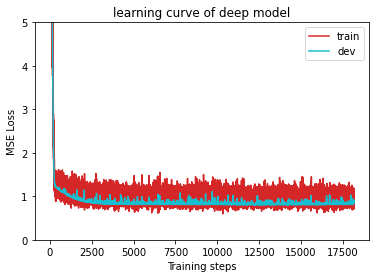

In [22]:
plot_learning_curve(model_loss_record,title='deep model')

### 查看拟合效果

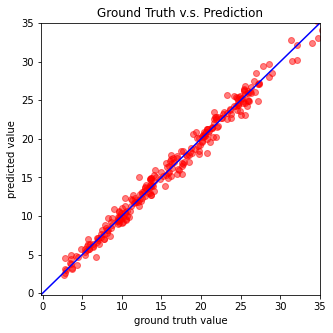

In [23]:
del model
model = NeuralNet(tr_set.dataset.dim).to(device)
ckpt = torch.load(config['save_path'],map_location='cpu')
model.load_state_dict(ckpt)
plot_pred(dv_set,model,device)

## 预测

In [24]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

preds = test(tt_set,model,device)  # predict COVID-19 cases with your model
save_pred(preds, 'pred.csv')  

Saving results to pred.csv
